# 1b. EEG Feature Extraction

## Run

- 1b EEG Feature Extraction [Jump To](#run-1b-eeg-feature-extraction)


## Some Ref Links

- The Brain Imaging Data Structure (BIDS): https://bids.neuroimaging.io
- MNE-Python: https://mne.tools/stable/index.html
- SpecParam: https://specparam-tools.github.io and https://github.com/fooof-tools

## Dependencies

General dependencies:
- python = 3.11.13
- numpy = 2.0.2
- scipy = 1.15.3
- pandas = 2.2.3
- matplotlib = 3.10.3

ML dependencies:
- scikit-learn = 1.6.1

EEG specific dependencies:
- mne = 1.9.0
- mne-icalabel = 0.7.0
- autoreject = 0.4.3
- specparam = 2.0.0rc3

# Imports & Utilities

In [1]:
# General imports
import os
import sys
import gc
import warnings

from datetime import datetime
from pprint import pprint
import time
import pickle
import random
from collections import Counter

# Custom Functions
sys.path.append(os.path.abspath('../Notebooks/Utilities')) 
import cust_utilities as utils

# Maths, Pandas etc
import math
import numpy as np
import pandas as pd
import scipy as sci

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

# MNE-Python
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components
from autoreject import AutoReject
from autoreject import get_rejection_threshold

# SpecParam
from specparam import SpectralGroupModel
from specparam.plts.spectra import plot_spectra
# from specparam import __version__ as specparam_version
# print('Current SpecParam version:', specparam_version)


# Functions

In [2]:
# Function to plot EEG Time Series & Save to PDF
#

def plot_EEG_TD(eeg_FIF, channels, time_range_s=[], pdf_file = None):
    
    """
    EEG Time Domain Plot.

    Parameters
    ----------
    eeg_FIF : FIF
    channels : [str] eg ['P5', 'Pz']
    time_range_s : [nn,nn]
    """

    # Channels Limit
    max_plots = 5
    if len(channels) > max_plots:
        channels = channels[:max_plots]

    # Time Range
    sfreq = eeg_FIF.info['sfreq']
    if time_range_s:
        start = int(time_range_s[0] * sfreq)
        stop = int(time_range_s[1] * sfreq)
    else:
        start = 0
        stop = None

    # Get signal and times for the elected channel(s)
    # Handle Epoched data
    if eeg_FIF.__class__.__name__.startswith('Raw'):
        signal, times = eeg_FIF.get_data(picks=channels, 
                                        start=start, stop=stop,
                                        return_times=True)
    else:
        # warnings.warn("Epoched data detected: plotting may not be accurate for all types.", UserWarning)
        # return
        signal = eeg_FIF.get_data(picks=channels)  # shape: (n_epochs, n_channels, n_times)
        signal = signal.mean(axis=0)  # shape: (n_channels, n_times)
        times = eeg_FIF.times  # shape: (n_times,)

    # plot and copy to pdf
    plt.figure(figsize=(12, 8))
    for i, ch_name in enumerate(channels):
        plt.plot(times, signal[i] * 1e6, label=ch_name, alpha=0.7, linewidth=0.6)
    plt.title('EEG Time Series - Channels: ' + ', '.join(channels))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    plt.tight_layout()
    if pdf_file:
        pdf_file.savefig()
    plt.show()

In [3]:
# Function to plot EEG Frequency Domain / PSD
#

def plot_EEG_PSD(spectra, channel):
    """
    EEG Frequency Domain / PSD Plot.

    Parameters
    ----------
    spectra : mne.Spectrum
    channel : str eg 'P5'
    """

    freqs = spectra.freqs
    powers = spectra.get_data(return_freqs=False)

    # Average power across all epochs for each channel
    if powers.ndim == 3:  # shape: (n_epochs, n_channels, n_freqs)
        powers = powers.mean(axis=0)  # shape: (n_channels, n_freqs)

    # print('Quick PSD')
    # spectra.plot()
    # plt.show()

    # Log-log plot for all channels
    plt.figure(figsize=(12, 6))
    for idx, ch in enumerate(spectra.ch_names):
        plt.loglog(freqs, powers[idx], alpha=0.5, label=ch if idx < 10 else None)  # label only first 10 for clarity
    plt.title(f"Power Spectrum (Log-Log) - All Channels ({spectra.method} method)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power ($V^2/Hz$)")
    plt.tight_layout()
    plt.show()

    # Log-lin plot for all channels
    plt.figure(figsize=(12, 6))
    for idx, ch in enumerate(spectra.ch_names):
         plt.semilogy(freqs, powers[idx], alpha=0.5, label=ch if idx < 10 else None)  # label only first 10 for clarity
    plt.title(f"Power Spectrum (Log-Lin) - All Channels ({spectra.method} method)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power ($V^2/Hz$)")
    plt.tight_layout()
    plt.show()

    # A selected channel
    ch_label = channel
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    fig.suptitle(f'Power Spectrum - Channel {ch_label} ({spectra.method} method)', fontsize=20)
    ax0.set_title('Log/Log')
    ax1.set_title('Log/Lin')
    plot_spectra(freqs, powers[spectra.ch_names.index(ch_label)], log_freqs=True, log_powers=True, ax=ax0, colors='blue')
    plot_spectra(freqs, powers[spectra.ch_names.index(ch_label)], log_powers=True, ax=ax1, colors='blue')
    plt.show()


In [4]:
# Function to perform Spectral Parameterisation and dtermine the aperiodic and periodic components
#

def perform_SpecParam(specparam_params, spectra):
    """
    Spectral Parameterisation to determine the aperiodic and periodic components for all channels

    Parameters
    ----------
    specparam_params : dic
    spectra : spectra

    Returns
    -------
    group_summary : pd series of group fit summary
    specparam_df : dataframe of components for each channel
    fg : SpectralGroup Model
    """

    flag_verbose = (True if 'VERBOSE' in globals() and VERBOSE else False)

    # Get powers and frrequency, if Epoched then average powers
    freqs = spectra.freqs
    powers = spectra.get_data(return_freqs=False)
    if powers.ndim == 3:  # shape: (n_epochs, n_channels, n_freqs)
        powers = np.mean(powers, axis=0)  # shape: (n_channels, n_freqs)

    # Initialise SpecParam Group Model & fit it
    fg = SpectralGroupModel(peak_width_limits=specparam_params['peak_width_limits'], 
                                max_n_peaks=specparam_params['max_n_peaks'], 
                                min_peak_height=specparam_params['min_peak_height'],
                                peak_threshold=specparam_params['peak_threshold'],
                                aperiodic_mode=specparam_params['aperiodic_mode'])
    progress_flag = 'tqdm.notebook' if flag_verbose else None
    fg.fit(freqs, powers, specparam_params['fit_freq_range'], progress=progress_flag, n_jobs=-1)

    # Check the quality of SpecParam Group fits
    fit_warning = False

    spectra_n = len(fg)
    null_fits = fg.n_null_
    if null_fits > 0:
        warnings.warn(f'Fits Failed: {null_fits} out of {spectra_n}', UserWarning)
        fit_warning = True

    r2s = fg.get_params('r_squared')
    mean_r2 = r2s.mean()
    std_r2 = r2s.std()
    if mean_r2 < specparam_params['fit_r2_threshold']:
        warnings.warn(f'SpecParam R2 mean {mean_r2:.2f} & std {std_r2:.2f}', UserWarning)
        fit_warning = True

    mean_peaks = len(fg.get_params('peak_params')) / spectra_n

    group_summary = pd.Series({
        'SPM_fit_quality_warning': fit_warning,
        'spectra_count': spectra_n,
        'null_fits': null_fits,
        'fit_r2_mean': mean_r2,
        'peaks_count_mean': mean_peaks
        })

    # Create a results dataframe
    specparam_df = fg.to_df(specparam_params['max_n_peaks'])   

    return group_summary, specparam_df, fg


In [5]:
# Function to plot SpecParam Results
#

def plot_SpecParam(fg, channel_indx, channel_name):
    """
    EEG SpecParam Results Plot

    Parameters
    ----------
    fg : SpecParamGroupModel
    """
    fm = fg.get_model(ind=channel_indx, regenerate=True)

    print(f'SpecParam for Channel: {channel_name}')
    fm.print_results()

    # fm.plot()
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    fig.suptitle(f'Spec Param for Channel: {channel_name}', fontsize=20)
    ax0.set_title('Components - Log/Lin')
    ax1.set_title('Components - Log/Log')
    fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'}, ax=ax0)
    fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'}, plt_log=True, ax=ax1)
    plt.show()


# Run: 1b EEG Feature Extraction

In [6]:
# Run Details & Parameters
#

# Study Details
study_name = 'IOWA_Rest'

# Get existing study details, if exists
study_folder_path = utils.get_folder_path('Study_' + study_name)
study_info = pd.read_pickle(study_folder_path + '/study_inf.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# Run Name, Data Source & Test Mode
run_description = 'features_sample_test'
data_source = '1a_EEG_Preprocessing_Results_20250702_sample_test'
test_mode = True

# Preprocessing Parameters for this run
psd_params = {'method': 'welch', #welch or multitaper (often used for epoched data)
              'fmin': 1, 'fmax': 100,       
              'exclude': []  # Includes all, even bad channels
              }
specparam_params = {'peak_width_limits': [1, 12],
                    'max_n_peaks': 10,
                    'min_peak_height': 0.1,
                    'peak_threshold': 2.0,
                    'aperiodic_mode': 'fixed',
                    'fit_freq_range' : [1, 100],
                    'fit_r2_threshold': 0.9
                     }

# Setup the processing run and results folder & save params
source_data_path = utils.get_folder_path(study_info['eeg_processing_results_path'] + '/' + data_source + '/EEG_2_cleaned_files' )
current_date = datetime.now().strftime('%Y%m%d')
run_name = f'1b_EEG_Features_Results_{current_date}_{run_description}'
run_results_path = utils.extend_folder_path(study_info['eeg_processing_results_path'], run_name, exists_ok=False)

run_details = pd.Series({
    'run_name': run_name,
    'study_name': study_name,
    'data_source': source_data_path,
    'psd_params': psd_params,
    'specparam_params': specparam_params,
})
run_details.to_pickle(run_results_path + '/run_details.pkl', compression='zip')

# Create empty study results
eeg_results_superset_df = pd.DataFrame()

# Set progress messages, testing
if test_mode:
    VERBOSE = True
    test_subjects = [0,5,101]
    test_channels = ['F4', 'C5', 'Cz', 'P6']
else:
    VERBOSE = False
    test_subjects = []
    test_channels = []
    
del current_date, study_name, run_description, study_folder_path


EEG Feature Extraction
- Study: IOWA_Rest ds004584-1.0.0
- Run: 1b_EEG_Features_Results_20250702_features_sample_test
- Data Source: /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/Study_IOWA_Rest/1_EEG_Processing_Results/1a_EEG_Preprocessing_Results_20250702_sample_test/EEG_2_cleaned_files
- PSD Params: {'method': 'welch', 'fmin': 1, 'fmax': 100, 'exclude': []}
- SpecParam Params: {'peak_width_limits': [1, 12], 'max_n_peaks': 10, 'min_peak_height': 0.1, 'peak_threshold': 2.0, 'aperiodic_mode': 'fixed', 'fit_freq_range': [1, 100], 'fit_r2_threshold': 0.9}

-----------------------------------------------------------------------------------------------
Subject: sub-001
---Get EEG Preprocessed Data - FIF ----------------------------------
Reading /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/Study_IOWA_Rest/1_EEG_Processing_Results/1a_EEG_Preprocessing_Results_20250702_sample_test/EEG_2_cleaned_files/sub-001_preprocessed_epo.fif ...
    Found the data of interest:
        t =       0.00 ...  

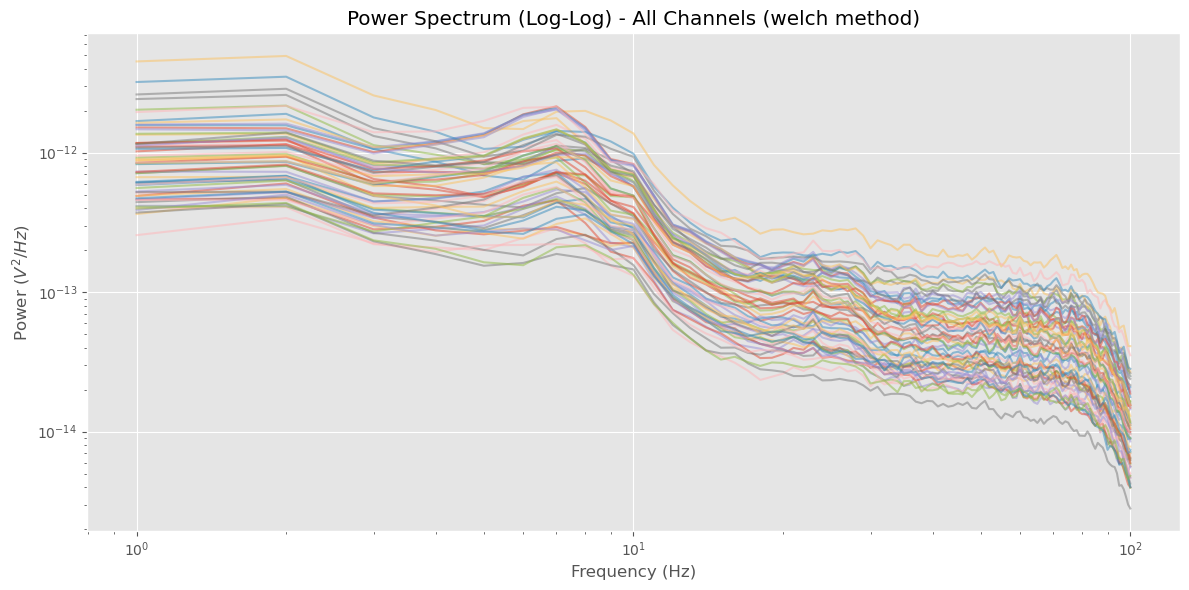

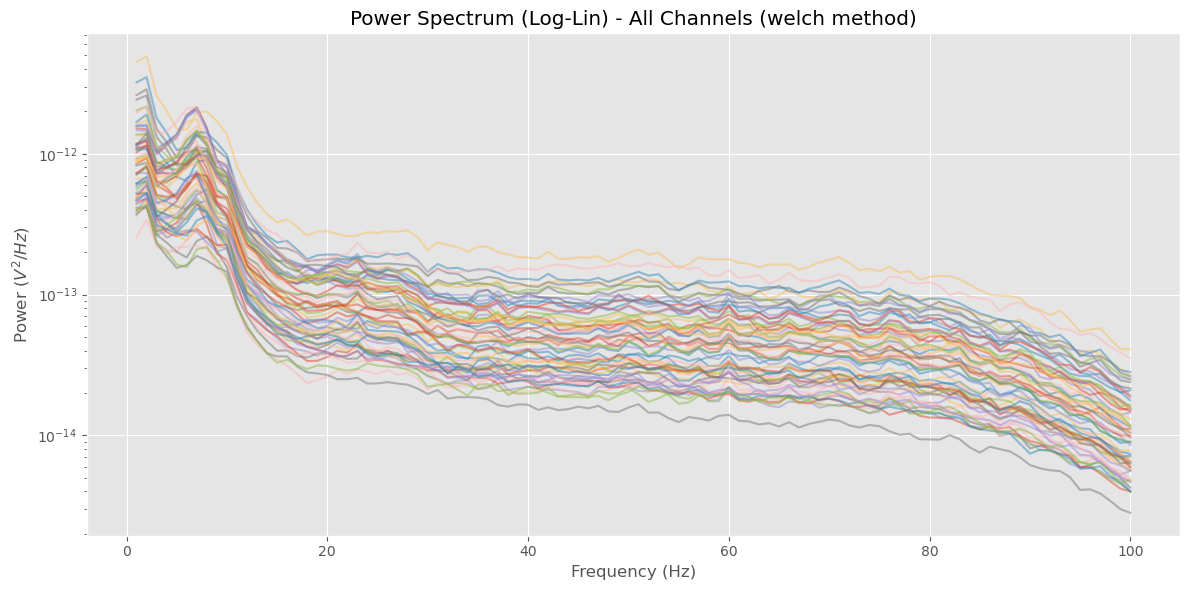

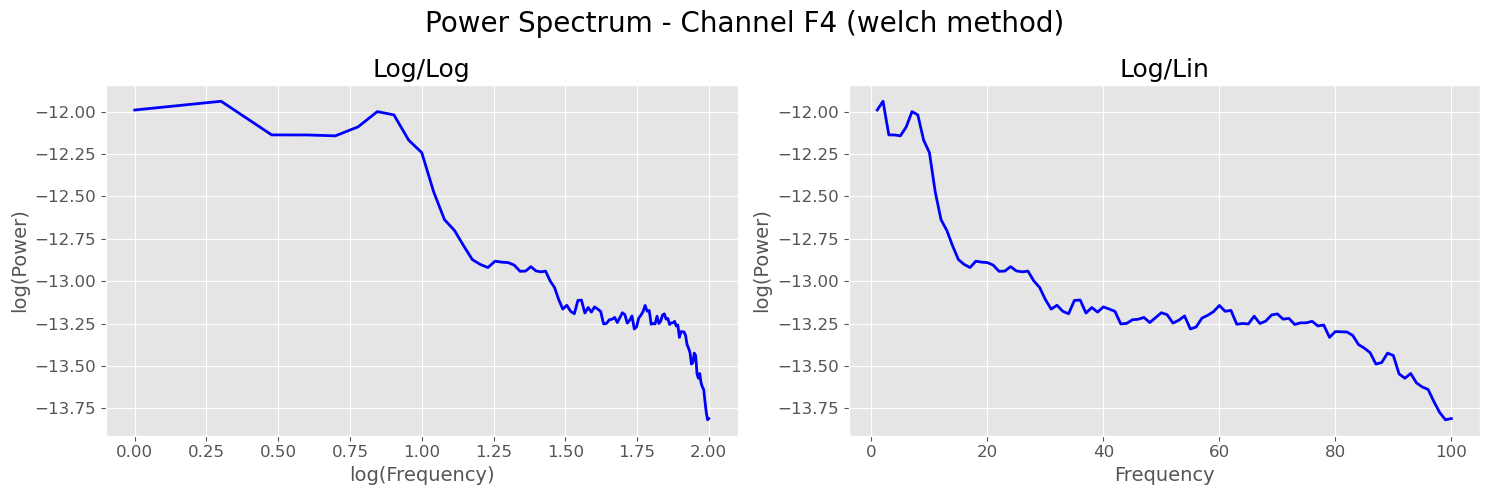

---EEG Spectral Parameterisation------------------------------------


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Executed Settings: ModelSettings(peak_width_limits=[1, 12], max_n_peaks=10, min_peak_height=0.1, peak_threshold=2.0, aperiodic_mode='fixed')
Group Summary: SPM_fit_quality_warning       False
spectra_count                    63
null_fits                         0
fit_r2_mean                0.974064
peaks_count_mean           3.952381
dtype: object
                                                                                                  
                                          GROUP RESULTS                                           
                                                                                                  
                             Number of power spectra in the Group: 63                          

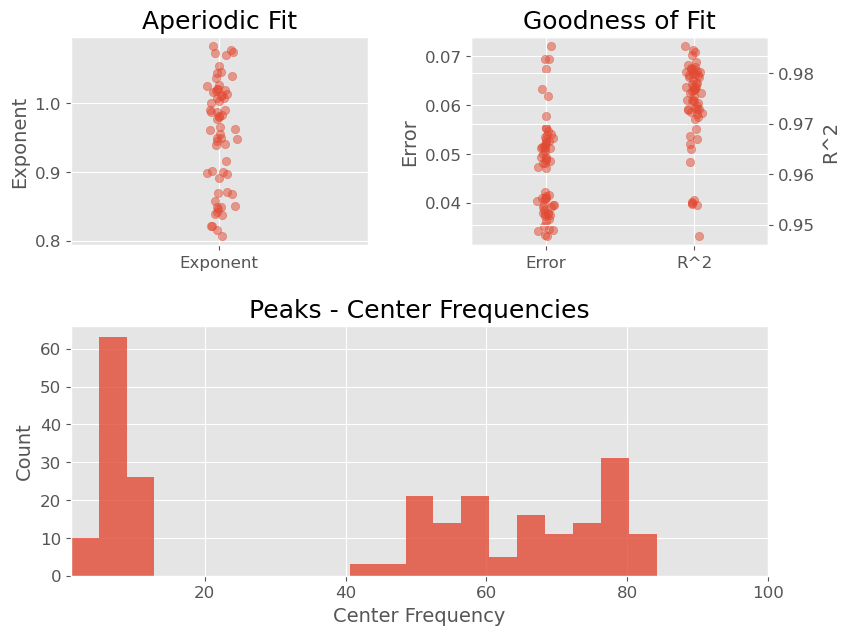

SpecParam for Channel: F4
                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -11.7085, 0.9415                                         
                                                                                                  
                                       4 peaks were found:                         

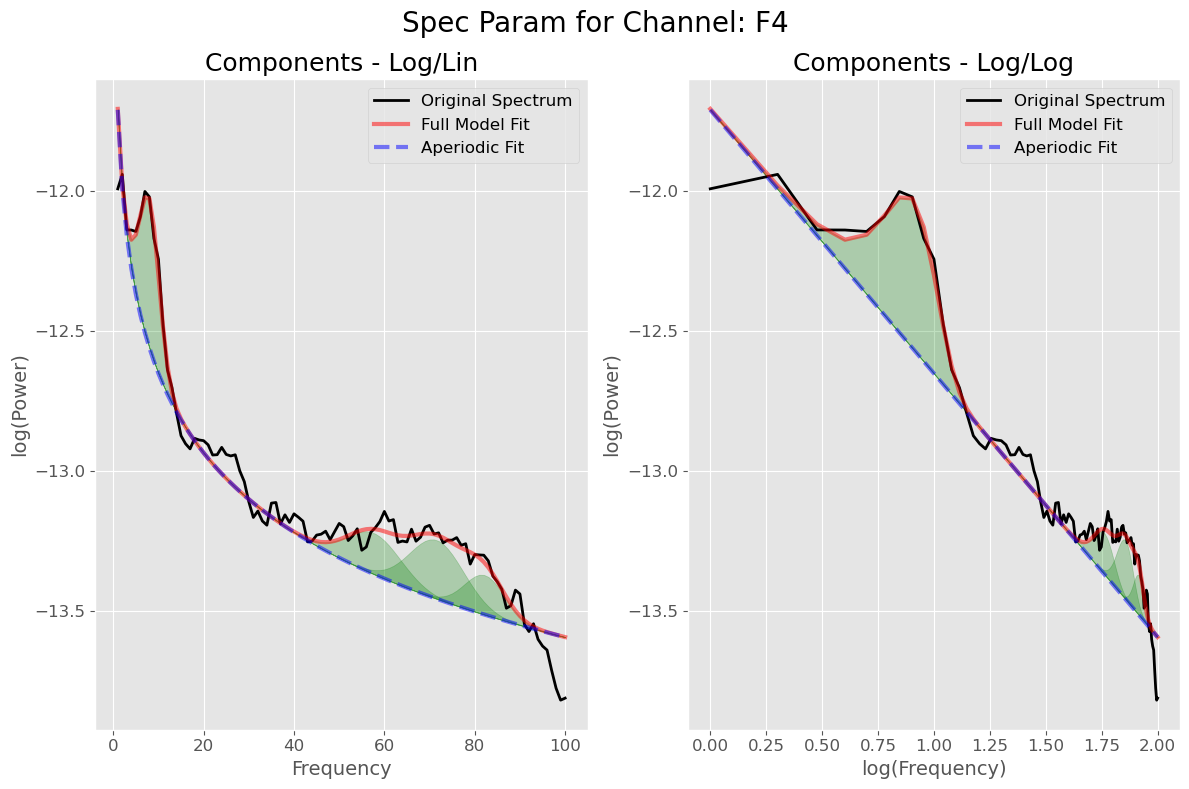

---Collating Results for sub-001 ------------------------------

-----------------------------------------------------------------------------------------------
Subject: sub-006
---Get EEG Preprocessed Data - FIF ----------------------------------
Reading /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/Study_IOWA_Rest/1_EEG_Processing_Results/1a_EEG_Preprocessing_Results_20250702_sample_test/EEG_2_cleaned_files/sub-006_preprocessed_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     998.00 ms
        0 CTF compensation matrices available
Not setting metadata
253 matching events found
No baseline correction applied
0 projection items activated
Description: None on None
<EpochsFIF | 253 events (all good), 0 – 0.998 s (baseline off), ~60.9 MiB, data loaded,
 '1': 253>
<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, P3, P7, ...
 chs: 63 EEG
 custom_ref_applied: True
 dig: 66 items (3 Cardinal, 63 EEG)
 file_id: 4 i

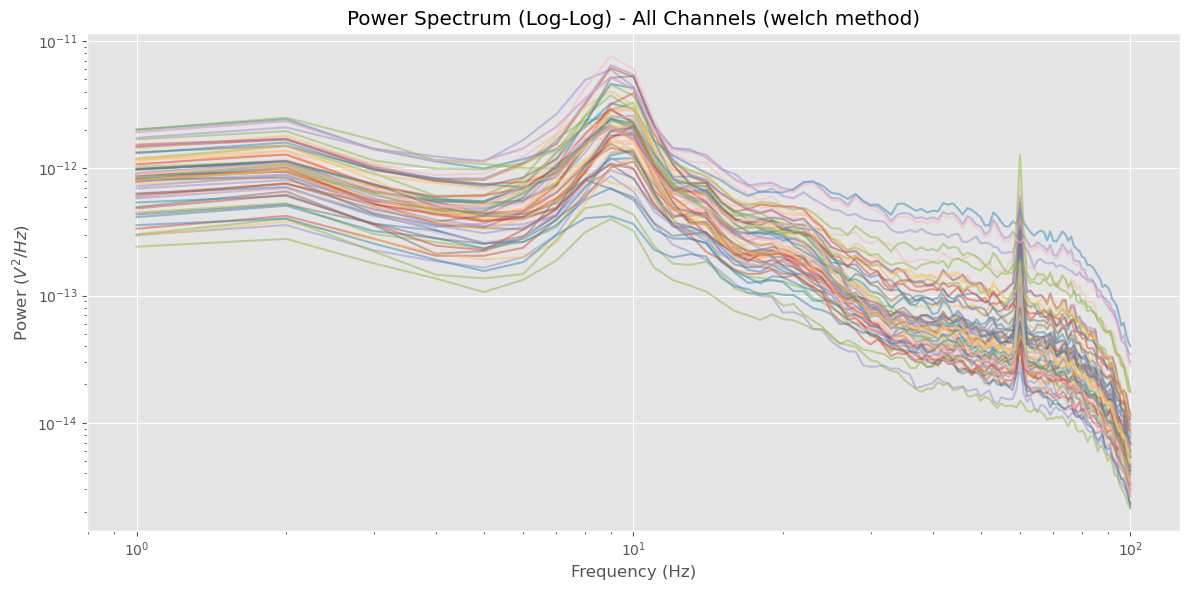

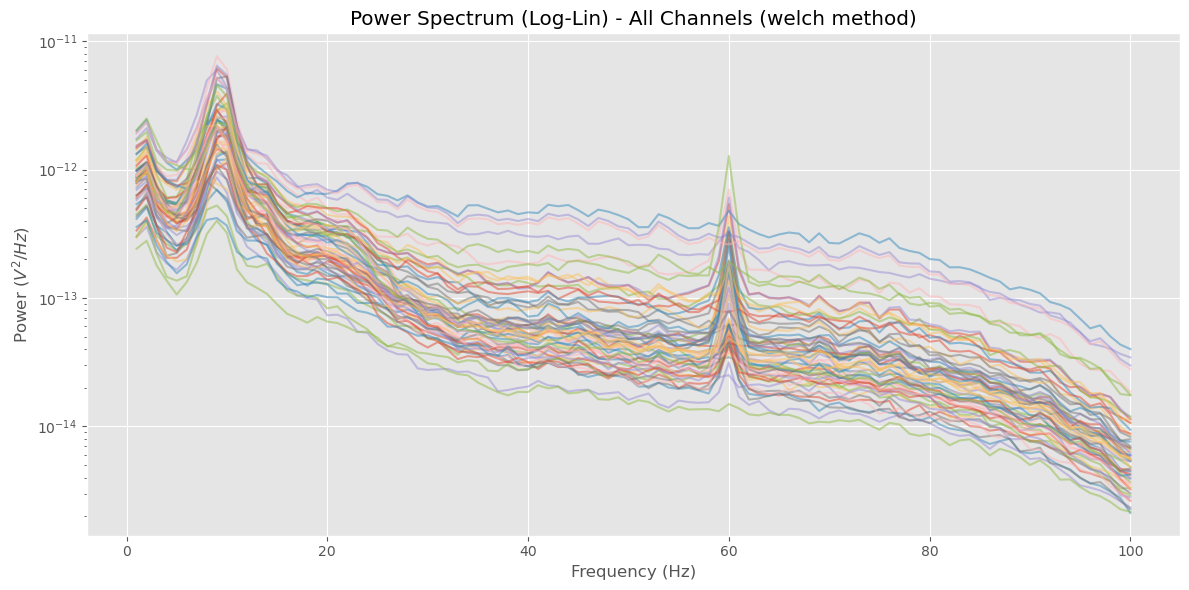

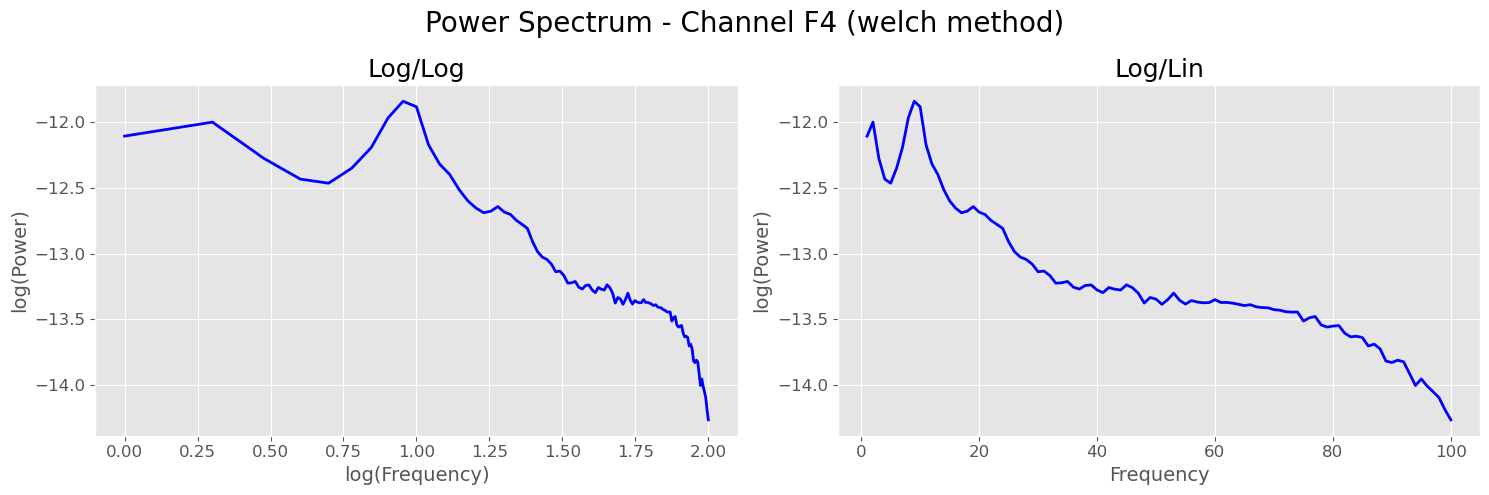

---EEG Spectral Parameterisation------------------------------------


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Executed Settings: ModelSettings(peak_width_limits=[1, 12], max_n_peaks=10, min_peak_height=0.1, peak_threshold=2.0, aperiodic_mode='fixed')
Group Summary: SPM_fit_quality_warning       False
spectra_count                    63
null_fits                         0
fit_r2_mean                 0.93278
peaks_count_mean           3.190476
dtype: object
                                                                                                  
                                          GROUP RESULTS                                           
                                                                                                  
                             Number of power spectra in the Group: 63                          

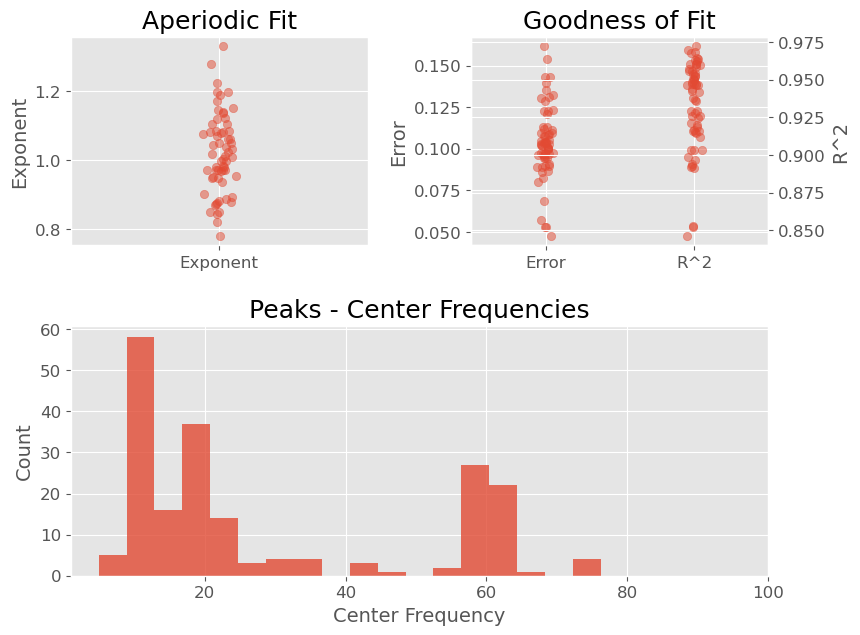

SpecParam for Channel: F4
                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -11.8067, 0.9510                                         
                                                                                                  
                                       2 peaks were found:                         

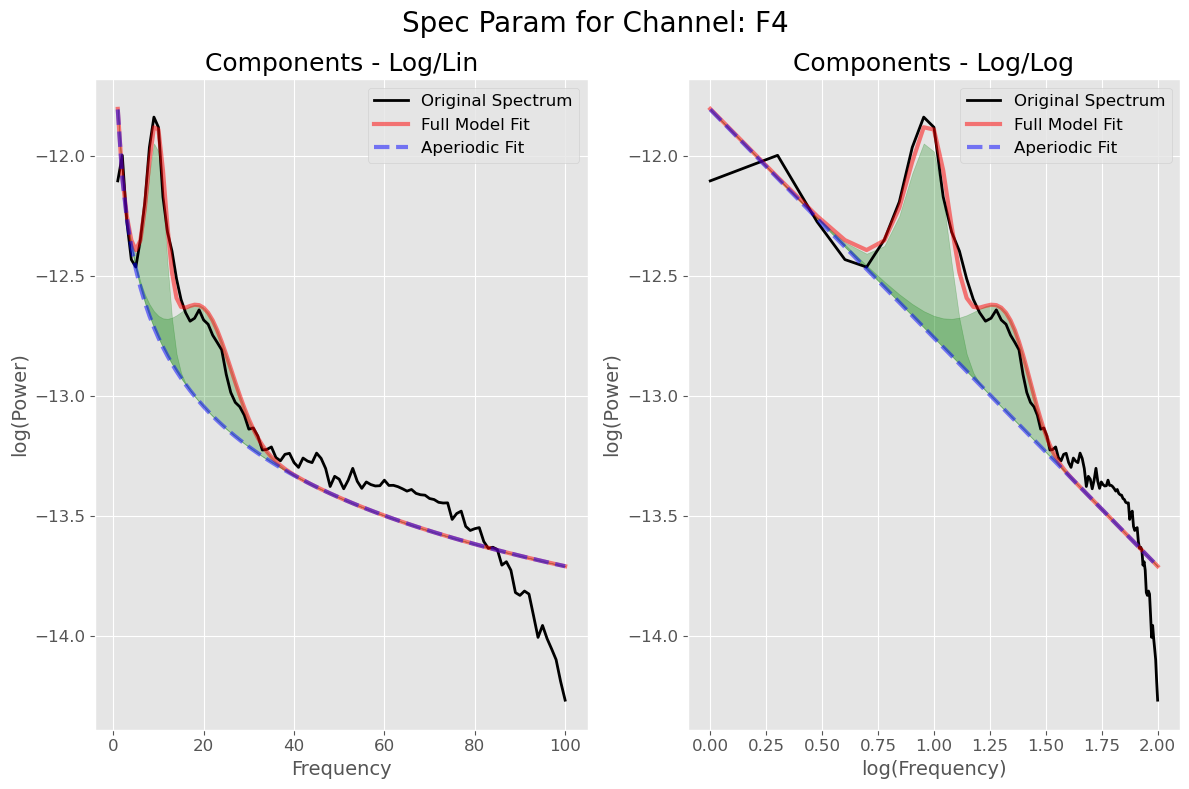

---Collating Results for sub-006 ------------------------------

-----------------------------------------------------------------------------------------------
Subject: sub-102
---Get EEG Preprocessed Data - FIF ----------------------------------
Reading /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/Study_IOWA_Rest/1_EEG_Processing_Results/1a_EEG_Preprocessing_Results_20250702_sample_test/EEG_2_cleaned_files/sub-102_preprocessed_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     998.00 ms
        0 CTF compensation matrices available
Not setting metadata
203 matching events found
No baseline correction applied
0 projection items activated
Description: None on None
<EpochsFIF | 203 events (all good), 0 – 0.998 s (baseline off), ~48.9 MiB, data loaded,
 '1': 203>
<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, P3, P7, ...
 chs: 63 EEG
 custom_ref_applied: True
 dig: 66 items (3 Cardinal, 63 EEG)
 file_id: 4 i

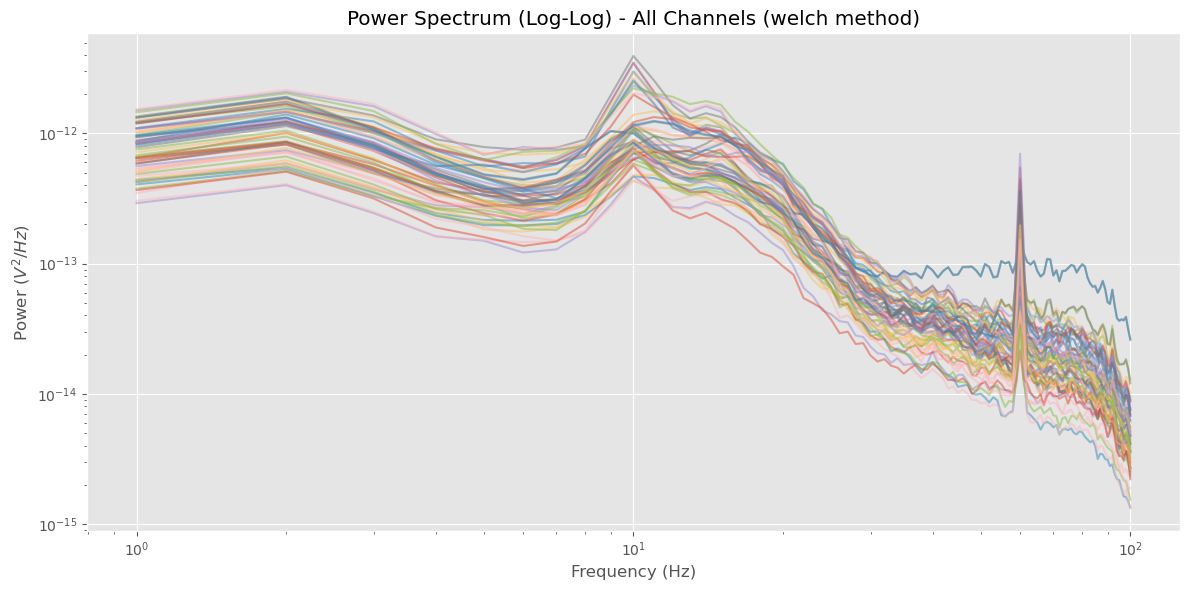

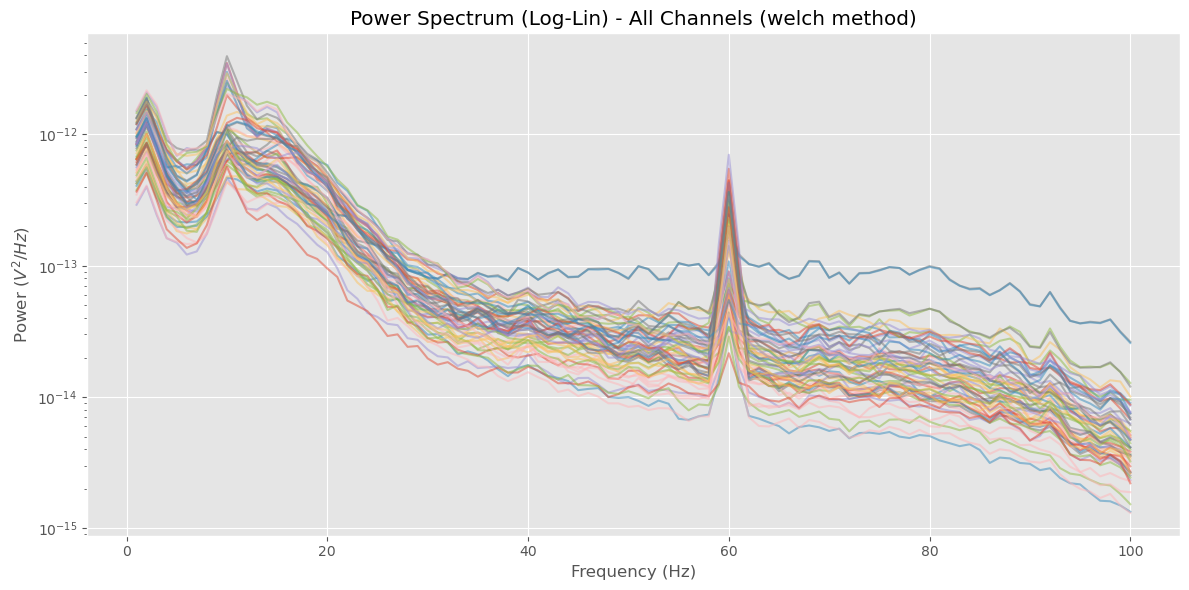

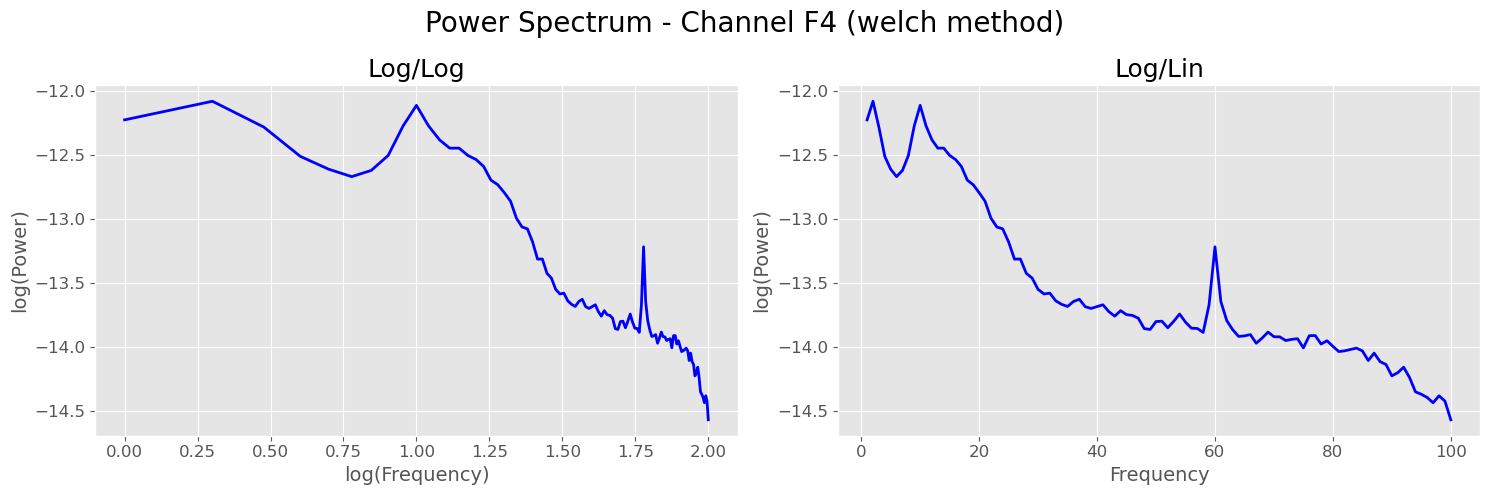

---EEG Spectral Parameterisation------------------------------------


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Executed Settings: ModelSettings(peak_width_limits=[1, 12], max_n_peaks=10, min_peak_height=0.1, peak_threshold=2.0, aperiodic_mode='fixed')
Group Summary: SPM_fit_quality_warning       False
spectra_count                    63
null_fits                         0
fit_r2_mean                0.973024
peaks_count_mean            3.68254
dtype: object
                                                                                                  
                                          GROUP RESULTS                                           
                                                                                                  
                             Number of power spectra in the Group: 63                          

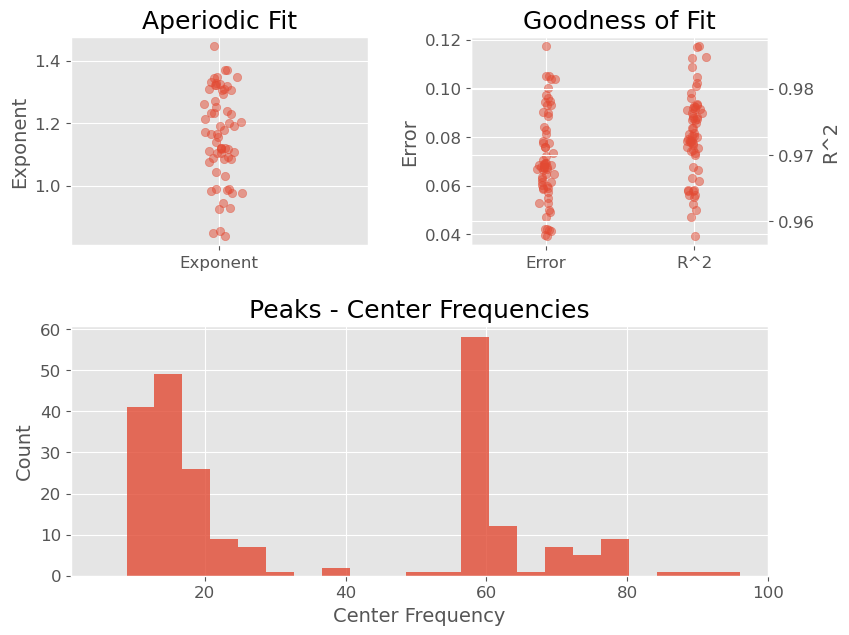

SpecParam for Channel: F4
                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -11.8332, 1.1734                                         
                                                                                                  
                                       4 peaks were found:                         

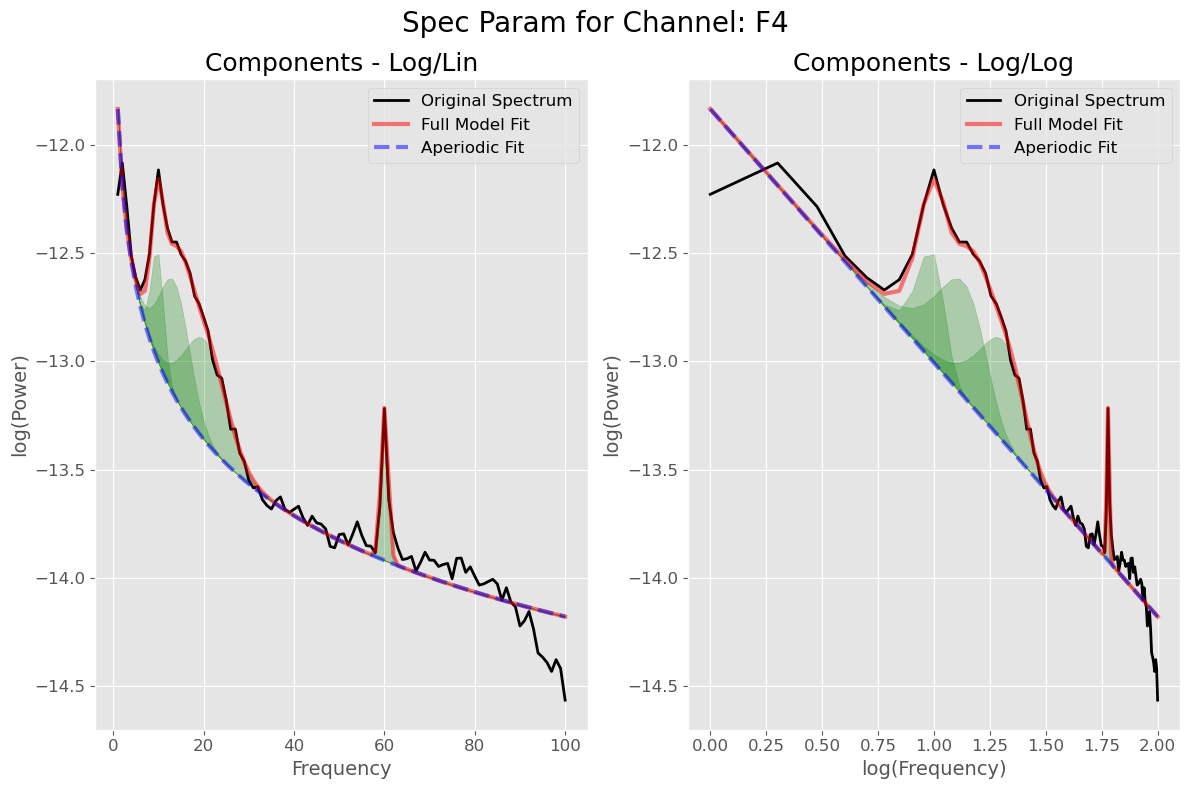

---Collating Results for sub-102 ------------------------------


In [7]:
# Run all the steps for EEG feature extraction
#

# Start Trace
summary = f'EEG Feature Extraction'
summary = summary + f"\n- Study: {study_info['study_name']} {study_info['dataset_ref']}"
summary = summary + f"\n- Run: {run_details['run_name']}"
summary = summary + f"\n- Data Source: {run_details['data_source']}"
summary = summary + f"\n- PSD Params: {psd_params}"
summary = summary + f"\n- SpecParam Params: {specparam_params}"
print(summary)

# Loop through all selected subjects in the study
for idx, subject in study_subjects_df.iterrows():

    # Just sample a subset of subjects when in test mode
    if test_mode and idx not in test_subjects:
        continue

    subject_id = subject['subject_id']
    print('\n-----------------------------------------------------------------------------------------------')
    print(f'Subject: {subject_id}')

    # 1. EEG Preprosessed Data Load
    #
    print('---Get EEG Preprocessed Data - FIF ----------------------------------')
    source_file_path = utils.get_file_path(source_data_path, f"{subject['subject_id']}_preprocessed_epo.fif")
    EEG_preprocessed = mne.read_epochs(source_file_path, preload=True, verbose=VERBOSE)
    preprocessing_results = pd.read_pickle(source_data_path + f'/{subject_id}_preprocessing_results.pkl', compression='zip')

    if VERBOSE:
        print(f"Description: {EEG_preprocessed.info['description']} on {EEG_preprocessed.info['meas_date']}")
        print(EEG_preprocessed)
        print(EEG_preprocessed.info)
        # plot_EEG_TD(EEG_preprocessed, test_channels)

    # 2. Power Spectra
    #
    print('---Power Spectra----------------------------------------------------')
    # NB: PSD defaults to Welch for continuous, Multitaper for epoched data, here will typically force to Welch
    psd = EEG_preprocessed.compute_psd(method=psd_params['method'],
                                      fmin=psd_params['fmin'],
                                      fmax=psd_params['fmax'], exclude=psd_params['exclude'])
    # spectra = get_spectra(psd_params, EEG_preprocessed)
    # if test_mode:
    #     psd_save_path = os.path.join(eeg_processing_run_path, f'{subject_id}_psd.npy')
    #     np.save(psd_save_path, temp_spectra.get_data())
    
    if VERBOSE:
        print(psd)
        print(psd.info)
        plot_EEG_PSD(psd, test_channels[0])

    # 3. Spectral Parameterisation
    #
    print('---EEG Spectral Parameterisation------------------------------------')
    group_summary, specparam_df, fg = perform_SpecParam(specparam_params, psd)

    if VERBOSE:
        print(f'Executed Settings: {fg.get_settings()}')
 
        # Overall group results
        print(f'Group Summary: {group_summary}')
        fg.print_results()
        fg.plot()
        plt.show()

        # Plot the test channels
        channel_idx = psd.ch_names.index(test_channels[0])
        plot_SpecParam(fg, channel_idx, test_channels[0])
    
    # 4. Subject Results
    #
    print(f'---Collating Results for {subject_id} ------------------------------')

    # TODO: Get the artefact results and include also
    subject_results = pd.concat([subject, preprocessing_results, group_summary])
    for idx, row in specparam_df.iterrows():
        row_series = pd.Series(row.values, index=[f'chn_{idx}_{col}' for col in row.index])
        subject_results = pd.concat([subject_results, row_series])
    
    # Append subject_results
    eeg_results_superset_df = pd.concat(
        [eeg_results_superset_df, subject_results.to_frame().T],
        ignore_index=True
    )

# Save all results
eeg_results_superset_df.to_pickle(run_results_path + '/eeg_results_superset_df.pkl', compression='zip')



# Run: 1c EEG Results Collation